# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Выгружаем csv-файл для ознакомления и работы в далее.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pprint

from pymystem3 import Mystem
from collections import Counter

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Сразу видно много Nan значений, возможно это помешает нам.

In [2]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


- Есть квартиры по 19 комнат, квартиры с 900 квадратными метрами, здания 60-ти этажные, квартиры с потолками 100м в высоту. Явно есть аномалии, либо необычные данные.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

- Nan значение слишком много
- Стобец с датой и временим надо привести в сооветсвующий тип datetime.
- Столбец is_apartment надо привести к булевому значению.
- В столбецы days_exposition, ponds_around3000, parks_around3000, balcony надо изменить тип на int
- Кол-во этажей надо привести  к целочисленному типу.
- Ну и расстояния до центра/аэропорта/водоема/парка тоже к целочисленным относятся, так как дробная часть в этом случае не важна.

In [4]:
data.duplicated().sum()

0

Полных дублей нет, уже хорошо. Есть несколько типов вида bool и один тип object is_apartment, по логике тоже можно привести к булевому

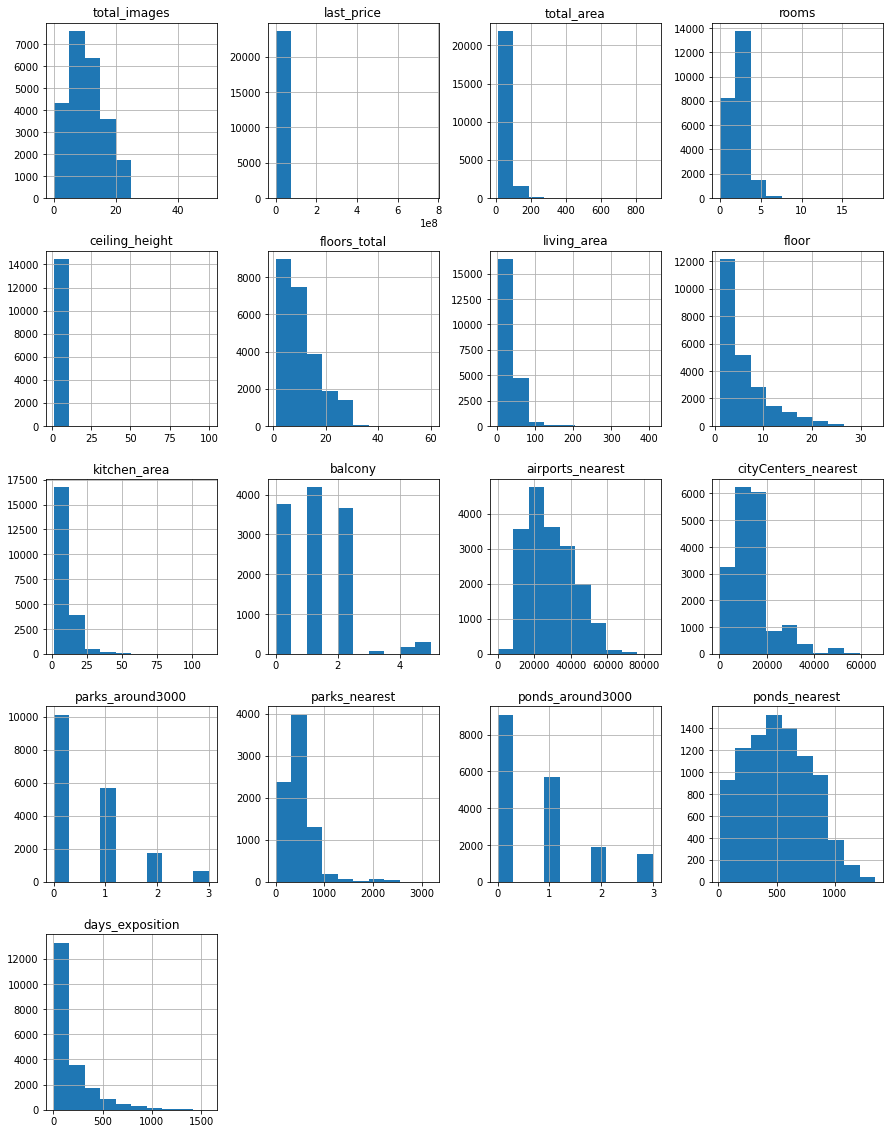

In [5]:
data.hist(figsize=(15, 20));

Что то не так со значения 'total_area', 'last_price', 'rooms', 'ceiling_height'

Булевы типы привел бы к одному виду уровня is_*. В ином виде некачественные названия столбцов
Так-же стоит поменять порядок столбцов, в данный момент он не несет много смысла

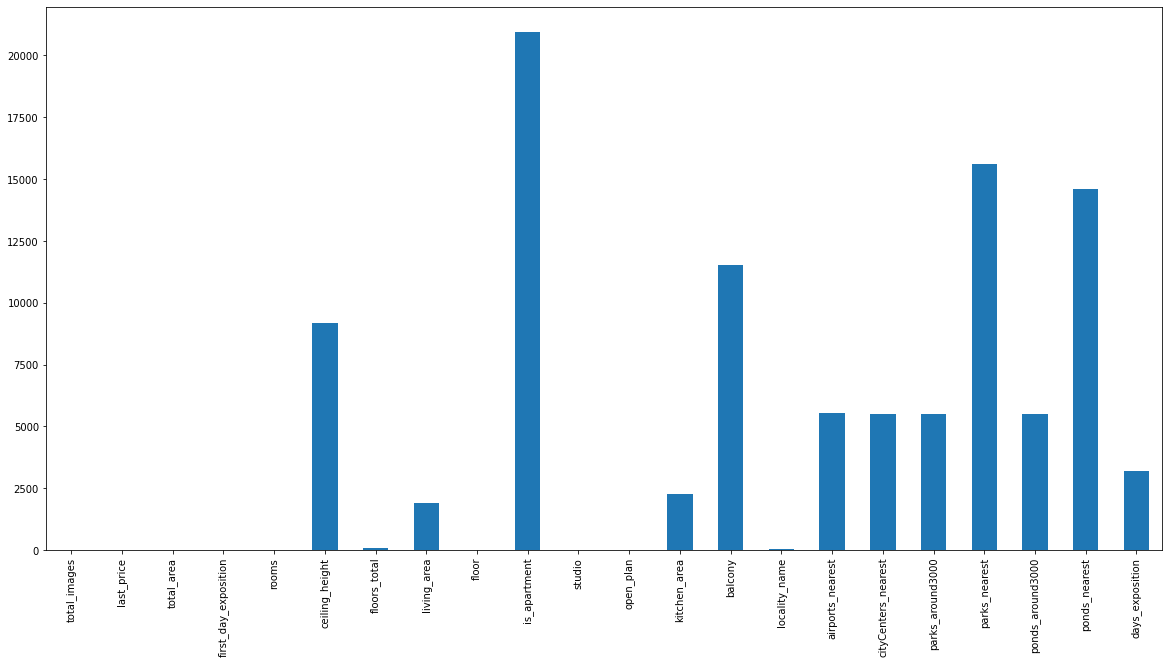

In [6]:
import matplotlib.pyplot as plt
#Создаем series с пропущенными значениями
nan_data = data.isna().sum()
#рисуем график для наглядности
nan_data.plot(kind="bar", figsize=(20,10));

- В столбе is_apartment слишком много пропусков, так как он булевый тип, то можно предположить что пропущенные значения означают отрицание, то есть можно заменить на 0.
- Так как в столбце balcony записано количество балконов, можно так же предположить, что пропущенные значения означают отсутствие балконов.
- Большое кол-во пропусков ceiling_height не возможно обьяснить, наверное придется заменить медианным значением, что бы не испортить данные.
- Так же много пропусков в столбцах расстояния до аэропорта/центра/водоема/парка.
- В столбцах расстояние до парка и водоема, NaN значений больше чем в стобцах об их наличии.
- Пропущенные значения kitchen_area можно обьяснить только тем, что это студия. 

***Вывод***

Данные изкажены, некоторые типы данных надо поменять. Обработать пропущенные значения, где надо заменить на медианное значение, а где-то на 0. Обработать выбросы тоже надо.

### Предобработка данных

In [7]:
#Посмотрим колонки для переименования
data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

In [8]:
# Переименуем столбы
columns = ['total_images',
        'last_price',
        'total_area',
        'first_day_exposition',
        'amount_of_rooms',
        'ceiling_height',
        'total_floors_in_building',
        'living_area',
        'floor',
        'is_apartment',
        'is_studio',
        'is_open_plan',
        'kitchen_area',
        'amount_of_balconies',
        'town_name',
        'nearest_airport_distance',
        'city_center_distance',
        'parks_numbers_within_3km',
        'nearest_park_distance',
        'ponds_number_within_3km',
        'nearest_pond_distance',
        'days_exposition']
data.set_axis(columns, axis='columns', inplace=True)
data.describe()

,total_images,last_price,total_area,amount_of_rooms,ceiling_height,total_floors_in_building,living_area,floor,kitchen_area,amount_of_balconies,nearest_airport_distance,city_center_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [9]:
#В идеале название города передвинуть на первое место, пока неочевидно что и главное где мы смотри
data = data[[
 'town_name',  
 'total_area', 
 'floor',
 'living_area',
 'kitchen_area',
 'ceiling_height',
 'amount_of_rooms',
 'amount_of_balconies',
 'total_floors_in_building',
 'is_apartment',
 'is_studio',
 'is_open_plan',  
 'total_images',
 'last_price',
 'first_day_exposition',
 'days_exposition',
 'city_center_distance',
 'nearest_airport_distance',
 'parks_numbers_within_3km',
 'nearest_park_distance',
 'ponds_number_within_3km',
 'nearest_pond_distance'
]]
data.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
0,Санкт-Петербург,108.0,8,51.0,25.0,2.70,3,NaN,16.0,NaN,False,False,20,13000000.0,2019-03-07T00:00:00,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0
1,посёлок Шушары,40.4,1,18.6,11.0,NaN,1,2.0,11.0,NaN,False,False,7,3350000.0,2018-12-04T00:00:00,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN
2,Санкт-Петербург,56.0,4,34.3,8.3,NaN,2,0.0,5.0,NaN,False,False,10,5196000.0,2015-08-20T00:00:00,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0
3,Санкт-Петербург,159.0,9,NaN,NaN,NaN,3,0.0,14.0,NaN,False,False,0,64900000.0,2015-07-24T00:00:00,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0
4,Санкт-Петербург,100.0,13,32.0,41.0,3.03,2,NaN,14.0,NaN,False,False,2,10000000.0,2018-06-19T00:00:00,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0


Сразу видно, что названия городов не приведены к единому регистру

In [10]:
#кол-во пропусков is_apartment
data['is_apartment'].isnull().sum()

20924

In [11]:
#Посчитаем все null значения
data.isnull().sum().sort_values()

is_studio                       0
total_area                      0
floor                           0
first_day_exposition            0
last_price                      0
total_images                    0
amount_of_rooms                 0
is_open_plan                    0
town_name                      49
total_floors_in_building       86
living_area                  1903
kitchen_area                 2278
days_exposition              3181
ponds_number_within_3km      5518
parks_numbers_within_3km     5518
city_center_distance         5519
nearest_airport_distance     5542
ceiling_height               9195
amount_of_balconies         11519
nearest_pond_distance       14589
nearest_park_distance       15620
is_apartment                20924
dtype: int64

In [12]:
#считаем буливы значения
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [13]:
data.describe()

,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,total_images,last_price,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
count,23699.000000,23699.000000,21796.000000,21421.000000,14504.000000,23699.000000,12180.000000,23613.000000,23699.000000,2.369900e+04,20518.000000,18180.000000,18157.000000,18181.000000,8079.000000,18181.000000,9110.000000
mean,60.348651,5.892358,34.457852,10.569807,2.771499,2.070636,1.150082,10.673824,9.858475,6.541549e+06,180.888634,14191.277833,28793.672193,0.611408,490.804555,0.770255,517.980900
std,35.654083,4.885249,22.030445,5.905438,1.261056,1.078405,1.071300,6.597173,5.682529,1.088701e+07,219.727988,8608.386210,12630.880622,0.802074,342.317995,0.938346,277.720643
min,12.000000,1.000000,2.000000,1.300000,1.000000,0.000000,0.000000,1.000000,0.000000,1.219000e+04,1.000000,181.000000,0.000000,0.000000,1.000000,0.000000,13.000000
25%,40.000000,2.000000,18.600000,7.000000,2.520000,1.000000,0.000000,5.000000,6.000000,3.400000e+06,45.000000,9238.000000,18585.000000,0.000000,288.000000,0.000000,294.000000
50%,52.000000,4.000000,30.000000,9.100000,2.650000,2.000000,1.000000,9.000000,9.000000,4.650000e+06,95.000000,13098.500000,26726.000000,0.000000,455.000000,1.000000,502.000000
75%,69.900000,8.000000,42.300000,12.000000,2.800000,3.000000,2.000000,16.000000,14.000000,6.800000e+06,232.000000,16293.000000,37273.000000,1.000000,612.000000,1.000000,729.000000
max,900.000000,33.000000,409.700000,112.000000,100.000000,19.000000,5.000000,60.000000,50.000000,7.630000e+08,1580.000000,65968.000000,84869.000000,3.000000,3190.000000,3.000000,1344.000000


Считаю нецелесообразным, пока  вместо пропущенных значений вставлять 0, так как это может испортить данные.

In [14]:
#заменяем пропущенные значения на 0 где это логично
data['amount_of_balconies'] = data['amount_of_balconies'].fillna(0)

- В стобце balcony пропуски могут быть, потому что человек заполнявший значениями просто не записал, из того что нет балконов.
- В стобцах parks_around3000 и parks_nearest, ponds_around3000 и ponds_nearest пока значения не трогаем, так как надо сгруппировать данные, а потом приступать к исправлению этих столбцов.

In [15]:
# Глянем на кейс с регистром городов, узнаем их количество сейчас
len(data['town_name'].unique())

365

In [16]:
# И приведенный к нижнему регистру
data['town_name'] = data['town_name'].str.lower()
len(data['town_name'].unique())

365

In [17]:
# Посмотим тогда на список
data['town_name'].unique().tolist()

['санкт-петербург',
 'посёлок шушары',
 'городской посёлок янино-1',
 'посёлок парголово',
 'посёлок мурино',
 'ломоносов',
 'сертолово',
 'петергоф',
 'пушкин',
 'деревня кудрово',
 'коммунар',
 'колпино',
 'поселок городского типа красный бор',
 'гатчина',
 'поселок мурино',
 'деревня фёдоровское',
 'выборг',
 'кронштадт',
 'кировск',
 'деревня новое девяткино',
 'посёлок металлострой',
 'посёлок городского типа лебяжье',
 'посёлок городского типа сиверский',
 'поселок молодцово',
 'поселок городского типа кузьмоловский',
 'садовое товарищество новая ропша',
 'павловск',
 'деревня пикколово',
 'всеволожск',
 'волхов',
 'кингисепп',
 'приозерск',
 'сестрорецк',
 'деревня куттузи',
 'посёлок аннино',
 'поселок городского типа ефимовский',
 'посёлок плодовое',
 'деревня заклинье',
 'поселок торковичи',
 'поселок первомайское',
 'красное село',
 'посёлок понтонный',
 'сясьстрой',
 'деревня старая',
 'деревня лесколово',
 'посёлок новый свет',
 'сланцы',
 'село путилово',
 'ивангород',
 '

In [18]:
# Рассмотрим классический кейс с заменой ё на е
data['town_name'] = data['town_name'].str.replace('ё', 'е', regex=True)
len(data['town_name'].unique())


331

In [19]:
# Так-же нашли неправильно введенные названия деревень и поселка. До этого убрали 34 дубля
data['town_name'] = data['town_name'].replace('посёлок сапёрный', 'посёлок сапёрное')
data['town_name'] = data['town_name'].replace('деревня курковицы', 'деревня куровицы')
data['town_name'] = data['town_name'].replace('деревня калитино', 'деревня кальтино')

In [20]:
# У нас 49 объявлений без города. Их следует удалить, так как это ключевая характеристика
data.isnull().sum().sort_values()

is_studio                       0
total_area                      0
floor                           0
first_day_exposition            0
last_price                      0
total_images                    0
amount_of_rooms                 0
amount_of_balconies             0
is_open_plan                    0
town_name                      49
total_floors_in_building       86
living_area                  1903
kitchen_area                 2278
days_exposition              3181
ponds_number_within_3km      5518
parks_numbers_within_3km     5518
city_center_distance         5519
nearest_airport_distance     5542
ceiling_height               9195
nearest_pond_distance       14589
nearest_park_distance       15620
is_apartment                20924
dtype: int64

In [21]:
data = data.dropna(subset=['town_name'])
data.isnull().sum().sort_values()

town_name                       0
first_day_exposition            0
last_price                      0
total_images                    0
is_open_plan                    0
amount_of_balconies             0
is_studio                       0
floor                           0
total_area                      0
amount_of_rooms                 0
total_floors_in_building       85
living_area                  1898
kitchen_area                 2269
days_exposition              3180
ponds_number_within_3km      5510
parks_numbers_within_3km     5510
city_center_distance         5511
nearest_airport_distance     5534
ceiling_height               9160
nearest_pond_distance       14565
nearest_park_distance       15586
is_apartment                20890
dtype: int64

In [22]:
data['is_apartment'].unique()
#У нас есть nan значения апортаментов, будем считать их как False

array([nan, False, True], dtype=object)

In [23]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].unique()

array([False,  True])

In [24]:
data['is_open_plan'].value_counts()

False    23583
True        67
Name: is_open_plan, dtype: int64

In [25]:
data['is_apartment'].value_counts()

False    23600
True        50
Name: is_apartment, dtype: int64

In [26]:
data['is_studio'].value_counts()

False    23501
True       149
Name: is_studio, dtype: int64

In [27]:
data['amount_of_rooms'].value_counts()

1     8036
2     7924
3     5797
4     1175
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: amount_of_rooms, dtype: int64

In [28]:
data['amount_of_balconies'].value_counts()

0.0    15238
1.0     4187
2.0     3658
5.0      304
4.0      182
3.0       81
Name: amount_of_balconies, dtype: int64

In [29]:
data.head(5)
# Первый день экспозиции не приведет к виду даты, надо заняться

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
0,санкт-петербург,108.0,8,51.0,25.0,2.70,3,0.0,16.0,False,False,False,20,13000000.0,2019-03-07T00:00:00,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0
1,поселок шушары,40.4,1,18.6,11.0,NaN,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04T00:00:00,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN
2,санкт-петербург,56.0,4,34.3,8.3,NaN,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20T00:00:00,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0
3,санкт-петербург,159.0,9,NaN,NaN,NaN,3,0.0,14.0,False,False,False,0,64900000.0,2015-07-24T00:00:00,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0
4,санкт-петербург,100.0,13,32.0,41.0,3.03,2,0.0,14.0,False,False,False,2,10000000.0,2018-06-19T00:00:00,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0


In [30]:
date_format = r"%Y-%m-%dT%H:%M:%S"
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format=date_format)
data.head(5)
# Для дальнейшего анализа можно разбить на года/месяцы/дни, но сейчас это неактуально

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
0,санкт-петербург,108.0,8,51.0,25.0,2.70,3,0.0,16.0,False,False,False,20,13000000.0,2019-03-07,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0
1,поселок шушары,40.4,1,18.6,11.0,NaN,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN
2,санкт-петербург,56.0,4,34.3,8.3,NaN,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0
3,санкт-петербург,159.0,9,NaN,NaN,NaN,3,0.0,14.0,False,False,False,0,64900000.0,2015-07-24,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0
4,санкт-петербург,100.0,13,32.0,41.0,3.03,2,0.0,14.0,False,False,False,2,10000000.0,2018-06-19,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0


In [31]:
data['total_area'].value_counts().sort_values()

55.06       1
57.86       1
43.75       1
111.40      1
127.21      1
169.50      1
216.10      1
167.50      1
191.20      1
283.30      1
52.39       1
166.80      1
35.93       1
31.09       1
193.00      1
60.16       1
21.60       1
38.16       1
215.20      1
494.10      1
49.35       1
364.70      1
149.20      1
90.02       1
65.94       1
57.32       1
29.99       1
45.25       1
75.65       1
55.64       1
44.11       1
55.56       1
58.38       1
44.18       1
34.26       1
65.76       1
30.61       1
22.40       1
31.59       1
297.50      1
24.62       1
101.10      1
236.40      1
112.50      1
34.17       1
25.48       1
37.77       1
152.70      1
123.50      1
127.78      1
316.30      1
68.05       1
28.66       1
46.83       1
99.88       1
112.40      1
34.53       1
60.84       1
151.17      1
43.06       1
14.00       1
178.50      1
70.05       1
32.11       1
53.45       1
245.40      1
41.68       1
52.05       1
133.81      1
24.30       1
160.20      1
43.04 

In [32]:
data.describe()

,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,total_images,last_price,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
count,23650.000000,23650.000000,21752.000000,21381.000000,14490.000000,23650.000000,23650.000000,23565.000000,23650.000000,2.365000e+04,20470.000000,18139.000000,18116.000000,18140.000000,8064.000000,18140.000000,9085.000000
mean,60.329069,5.893277,34.448356,10.566403,2.771287,2.070106,0.591712,10.675875,9.862326,6.541127e+06,180.753200,14197.860742,28803.225878,0.611577,490.830729,0.769680,518.059879
std,35.661808,4.883317,22.037664,5.901753,1.261593,1.078620,0.959662,6.594823,5.682278,1.089640e+07,219.777916,8606.830295,12637.314144,0.802003,342.554386,0.937948,277.841733
min,12.000000,1.000000,2.000000,1.300000,1.000000,0.000000,0.000000,1.000000,0.000000,1.219000e+04,1.000000,181.000000,0.000000,0.000000,1.000000,0.000000,13.000000
25%,40.000000,2.000000,18.600000,7.000000,2.520000,1.000000,0.000000,5.000000,6.000000,3.400000e+06,45.000000,9241.000000,18575.750000,0.000000,288.000000,0.000000,293.000000
50%,52.000000,4.000000,30.000000,9.100000,2.650000,2.000000,0.000000,9.000000,9.000000,4.650000e+06,95.000000,13105.000000,26756.500000,0.000000,454.500000,1.000000,502.000000
75%,69.700000,8.000000,42.300000,12.000000,2.800000,3.000000,1.000000,16.000000,14.000000,6.799000e+06,231.000000,16293.000000,37294.000000,1.000000,612.000000,1.000000,730.000000
max,900.000000,33.000000,409.700000,112.000000,100.000000,19.000000,5.000000,60.000000,50.000000,7.630000e+08,1580.000000,65968.000000,84869.000000,3.000000,3190.000000,3.000000,1344.000000


In [33]:
def distance_center(distance):
    if distance['city_center_distance'] < 3000:
        return "центр"
    elif 3000 < distance['city_center_distance'] < 4000:
        return "рядом_с_центром"
    elif 6000 < distance['city_center_distance'] < 12000:
        return "окраины"
    elif 12000 < distance['city_center_distance'] < 24000:
        return "пригород"
    else:
        return "область"

- Сгруппируем по расстоянию от центра, скорее всего от расстояния что-то зависит! Например в центре Москвы потолки высокие, например Сталинские  высотки и т.д.

In [34]:
data['distance_category'] = data.apply(distance_center, axis=1)

In [35]:
data['distance_category'].head(10)

0    пригород
1    пригород
2    пригород
3     окраины
4     окраины
5     область
6    пригород
7     окраины
8     область
9    пригород
Name: distance_category, dtype: object

- Теперь есть новый столбец с категорией расстояние от центра, можно отталкиваться от него.

In [36]:
data.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category
0,санкт-петербург,108.0,8,51.0,25.0,2.70,3,0.0,16.0,False,False,False,20,13000000.0,2019-03-07,NaN,16028.0,18863.0,1.0,482.0,2.0,755.0,пригород
1,поселок шушары,40.4,1,18.6,11.0,NaN,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород
2,санкт-петербург,56.0,4,34.3,8.3,NaN,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород
3,санкт-петербург,159.0,9,NaN,NaN,NaN,3,0.0,14.0,False,False,False,0,64900000.0,2015-07-24,424.0,6800.0,28098.0,2.0,84.0,3.0,234.0,окраины
4,санкт-петербург,100.0,13,32.0,41.0,3.03,2,0.0,14.0,False,False,False,2,10000000.0,2018-06-19,121.0,8098.0,31856.0,2.0,112.0,1.0,48.0,окраины


In [37]:
# Рассмотрим внимательнее расстояние
category_pivot = data.groupby('distance_category')['ceiling_height'].mean().sort_values(ascending=False).to_frame()
category_pivot

,ceiling_height
distance_category,
рядом_с_центром,3.299767
центр,3.235521
окраины,2.808967
область,2.780516
пригород,2.670136


In [38]:
print(category_pivot.get(key='ceiling_height')['рядом_с_центром'])

3.299767441860467


Зависимость высоты потолка от расстояния.

In [39]:
data['ceiling_height'] = data.groupby('distance_category')['ceiling_height'].apply(lambda x: x.fillna(x.mean()))

Методом проб и ошибок выявил удачный однострочник, который помог заполнить пустые значения в столбце высота потолка.

In [40]:
data['ceiling_height'].isna().sum()

0

Видно что пустых значений не осталось.

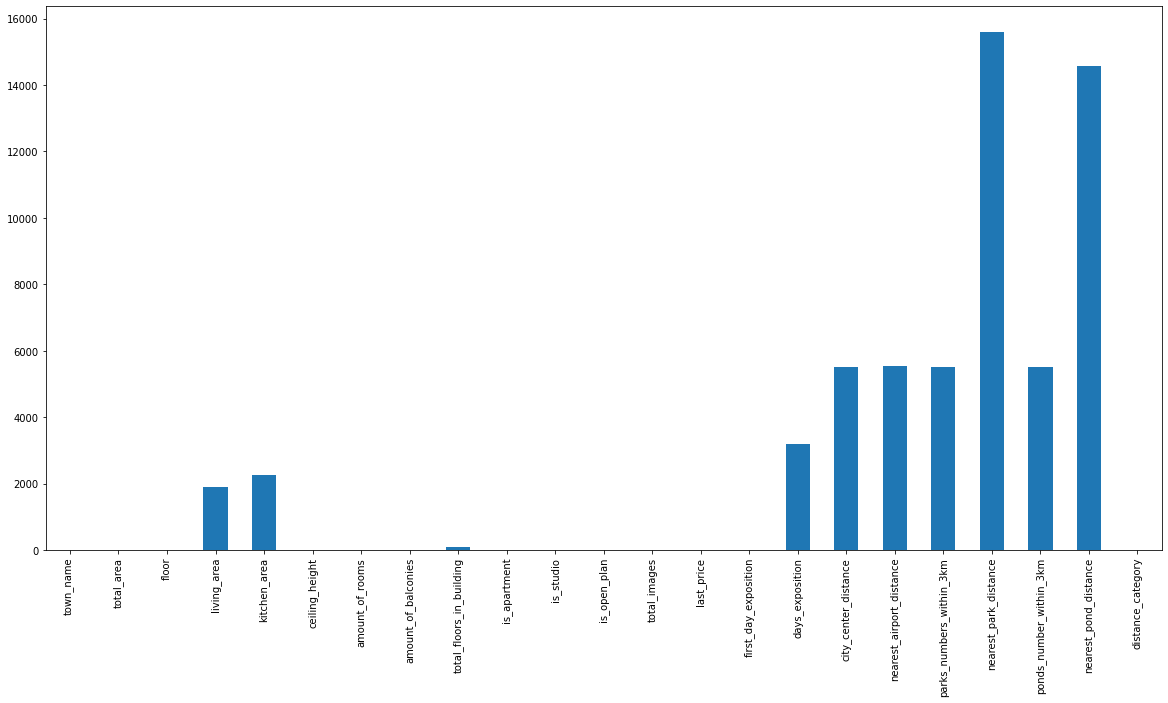

In [41]:
nan_data = data.isna().sum()
#рисуем график для наглядности
nan_data.plot(kind="bar", figsize=(20,10));

По  графику тоже видно что NAN значений нет.

In [42]:
data['amount_of_balconies'].value_counts()

0.0    15238
1.0     4187
2.0     3658
5.0      304
4.0      182
3.0       81
Name: amount_of_balconies, dtype: int64

In [43]:
data['amount_of_balconies'].isna().sum()

0

In [44]:
# Заменим балконы null на 0
data['amount_of_balconies'] = data['amount_of_balconies'].fillna(0)
data['amount_of_balconies'].value_counts()

0.0    15238
1.0     4187
2.0     3658
5.0      304
4.0      182
3.0       81
Name: amount_of_balconies, dtype: int64

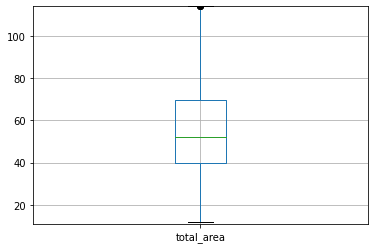

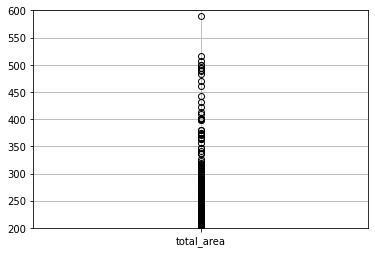

In [45]:
plt.ylim(11, 114)
data.boxplot('total_area');
plt.show()

plt.ylim(200, 600)
data.boxplot('total_area');
data_normal = data[(data['total_area'] < 150)]

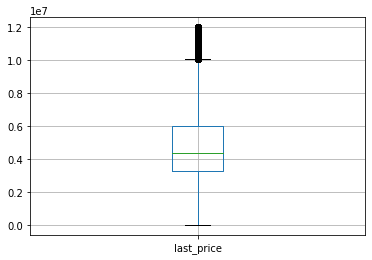

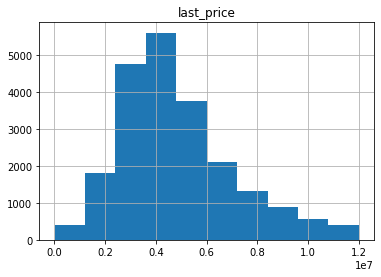

In [46]:
data_normal = data_normal[data_normal['last_price'] < 12000000]
data_normal.boxplot('last_price');
plt.show()

data_normal.hist('last_price');


По графикам видно, что большая часть квартир продается в диапозоне от 500 тыс.р. до 11 млн.р.. сделаем срез до 12 млн.р. остальное отбросим как выброс.

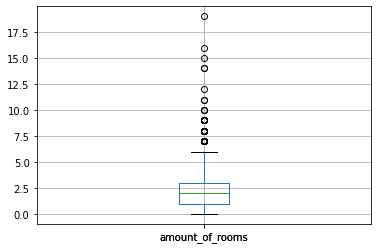

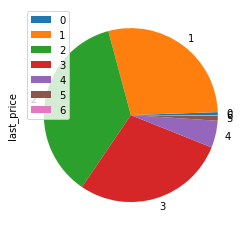

In [47]:
data.boxplot('amount_of_rooms')
data_normal = data_normal[data_normal['amount_of_rooms'] < 7]
data_normal.boxplot('amount_of_rooms');
#plt.show();

#room = normal_amount_of_rooms_df.groupby('amount_of_rooms').count()
data_normal.groupby(['amount_of_rooms']).sum().plot(kind='pie', y = 'last_price');


Из графиков видно, что есть большое каличество квартир с 0 комнат, скажем что это студия, больше 6ти комнат тоже редкость, поэтому сделаем срез на 6ти комнатах.

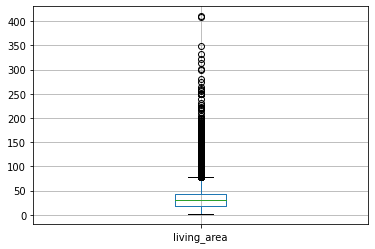

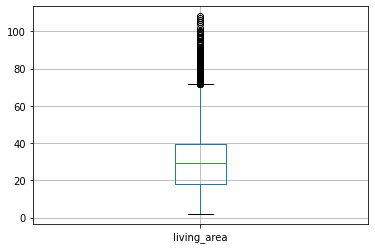

In [48]:

data_normal = data_normal[data_normal['living_area'] < 125]
data.boxplot('living_area');
plt.show()
data_normal.boxplot('living_area');


Отбросим выбросы и получается, что в основном квартиры продаются от 12 кв.м. до 76 кв.м.

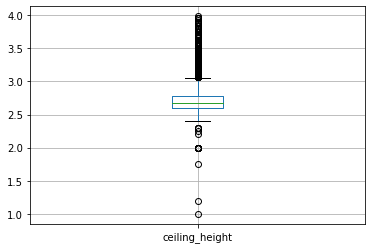

In [49]:
data_normal = data_normal[data_normal['ceiling_height'] < 4]
data_normal.boxplot('ceiling_height');

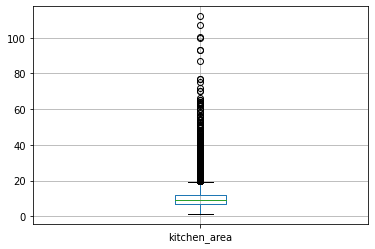

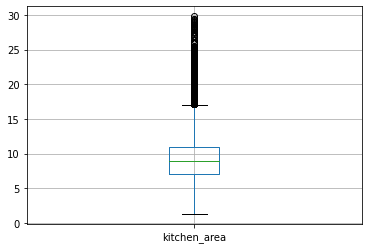

In [50]:
data.boxplot('kitchen_area')
plt.show()
data_normal = data_normal[data_normal['kitchen_area'] < 30]
data_normal.boxplot('kitchen_area');

**Вывод**
- Была проведена предобработка данных. Исправил формат даты, убрал пропуски, название городов привел к строчному типу данных и исправил регист, обработал выбросы, что бы потом построит гистограммы, проверил данные для дальнейшей работы.

In [51]:
data_normal.describe()

,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,total_images,last_price,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance
count,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19037.000000,19067.000000,1.906700e+04,16675.000000,14466.000000,14455.000000,14467.000000,6047.000000,14467.000000,6871.000000
mean,53.613651,5.841978,30.728716,9.498513,2.709606,1.956679,0.617821,10.650418,9.892852,4.890642e+06,177.774093,15019.326144,28907.067727,0.558512,487.094427,0.702910,532.067676
std,18.592160,4.837802,13.392657,3.484910,0.187488,0.895933,0.950469,6.549689,5.526720,2.204275e+06,213.762623,8599.133849,12993.321753,0.763705,324.843018,0.891652,277.428062
min,14.000000,1.000000,2.000000,1.300000,1.000000,1.000000,0.000000,1.000000,0.000000,4.300000e+05,1.000000,208.000000,0.000000,0.000000,1.000000,0.000000,16.000000
25%,39.500000,2.000000,18.200000,7.000000,2.600000,1.000000,0.000000,5.000000,6.000000,3.400000e+06,43.000000,10659.250000,18012.000000,0.000000,289.000000,0.000000,315.000000
50%,50.000000,4.000000,29.500000,9.000000,2.670136,2.000000,0.000000,9.000000,10.000000,4.490000e+06,97.000000,13628.000000,27059.000000,0.000000,456.000000,0.000000,521.000000
75%,64.000000,8.000000,39.600000,11.000000,2.780516,3.000000,1.000000,15.000000,14.000000,6.000000e+06,228.000000,16672.000000,37552.000000,1.000000,612.000000,1.000000,745.000000
max,149.000000,33.000000,108.000000,29.800000,3.980000,6.000000,5.000000,60.000000,39.000000,1.199900e+07,1580.000000,65968.000000,84869.000000,3.000000,3190.000000,3.000000,1344.000000


### Посчитайте и добавьте в таблицу новые столбцы

In [52]:
# Добавим базовый показатель - цена за метр квадратный
data_normal['price_per_meter'] = data_normal['last_price'] / data_normal['total_area']
data_normal.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter
1,поселок шушары,40.40,1,18.60,11.00,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079
2,санкт-петербург,56.00,4,34.30,8.30,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286
5,городской поселок янино-1,30.40,5,14.40,9.10,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474
6,поселок парголово,37.30,6,10.60,14.40,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456
8,поселок мурино,33.16,26,15.43,8.81,2.780516,1,0.0,27.0,False,False,False,20,2900000.0,2018-05-23,189.0,NaN,NaN,NaN,NaN,NaN,NaN,область,87454.764777


In [53]:
# Добавим колонки с годом, месяцем и днем
data_normal['day_exposition'] = data_normal['first_day_exposition'].dt.day_name()
data_normal['month_exposition'] = data_normal['first_day_exposition'].dt.month_name()
data_normal['year_exposition'] = data_normal['first_day_exposition'].dt.year
data_normal.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition
1,поселок шушары,40.40,1,18.60,11.00,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079,Tuesday,December,2018
2,санкт-петербург,56.00,4,34.30,8.30,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015
5,городской поселок янино-1,30.40,5,14.40,9.10,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474,Monday,September,2018
6,поселок парголово,37.30,6,10.60,14.40,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456,Thursday,November,2017
8,поселок мурино,33.16,26,15.43,8.81,2.780516,1,0.0,27.0,False,False,False,20,2900000.0,2018-05-23,189.0,NaN,NaN,NaN,NaN,NaN,NaN,область,87454.764777,Wednesday,May,2018


Ввожу новый столбец "type_floor" тип этажа.

In [54]:
# Добавим этажи
def floor_status(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['total_floors_in_building']:
        return 'последний'
    else:
        return 'другой'

In [55]:
data_normal['floor_status'] = data_normal.apply(floor_status, axis=1)
data_normal.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition,floor_status
1,поселок шушары,40.40,1,18.60,11.00,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079,Tuesday,December,2018,первый
2,санкт-петербург,56.00,4,34.30,8.30,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015,другой
5,городской поселок янино-1,30.40,5,14.40,9.10,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474,Monday,September,2018,другой
6,поселок парголово,37.30,6,10.60,14.40,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456,Thursday,November,2017,другой
8,поселок мурино,33.16,26,15.43,8.81,2.780516,1,0.0,27.0,False,False,False,20,2900000.0,2018-05-23,189.0,NaN,NaN,NaN,NaN,NaN,NaN,область,87454.764777,Wednesday,May,2018,другой


In [56]:
data_normal['cityCenters_distance_km'] = data_normal['city_center_distance'] / 1000
#округление до целых
data_normal.cityCenters_distance_km = data_normal.cityCenters_distance_km.round()

In [57]:
data_normal.head()

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition,floor_status,cityCenters_distance_km
1,поселок шушары,40.40,1,18.60,11.00,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079,Tuesday,December,2018,первый,19.0
2,санкт-петербург,56.00,4,34.30,8.30,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015,другой,14.0
5,городской поселок янино-1,30.40,5,14.40,9.10,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474,Monday,September,2018,другой,NaN
6,поселок парголово,37.30,6,10.60,14.40,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456,Thursday,November,2017,другой,19.0
8,поселок мурино,33.16,26,15.43,8.81,2.780516,1,0.0,27.0,False,False,False,20,2900000.0,2018-05-23,189.0,NaN,NaN,NaN,NaN,NaN,NaN,область,87454.764777,Wednesday,May,2018,другой,NaN


In [58]:
data_normal.describe()

,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,total_images,last_price,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,price_per_meter,year_exposition,cityCenters_distance_km
count,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19067.000000,19037.000000,19067.000000,1.906700e+04,16675.000000,14466.000000,14455.000000,14467.000000,6047.000000,14467.000000,6871.000000,19067.000000,19067.000000,14466.000000
mean,53.613651,5.841978,30.728716,9.498513,2.709606,1.956679,0.617821,10.650418,9.892852,4.890642e+06,177.774093,15019.326144,28907.067727,0.558512,487.094427,0.702910,532.067676,92038.397433,2017.371060,15.015554
std,18.592160,4.837802,13.392657,3.484910,0.187488,0.895933,0.950469,6.549689,5.526720,2.204275e+06,213.762623,8599.133849,12993.321753,0.763705,324.843018,0.891652,277.428062,28925.121402,1.025167,8.601520
min,14.000000,1.000000,2.000000,1.300000,1.000000,1.000000,0.000000,1.000000,0.000000,4.300000e+05,1.000000,208.000000,0.000000,0.000000,1.000000,0.000000,16.000000,9615.384615,2014.000000,0.000000
25%,39.500000,2.000000,18.200000,7.000000,2.600000,1.000000,0.000000,5.000000,6.000000,3.400000e+06,43.000000,10659.250000,18012.000000,0.000000,289.000000,0.000000,315.000000,75000.000000,2017.000000,11.000000
50%,50.000000,4.000000,29.500000,9.000000,2.670136,2.000000,0.000000,9.000000,10.000000,4.490000e+06,97.000000,13628.000000,27059.000000,0.000000,456.000000,0.000000,521.000000,92558.139535,2017.000000,14.000000
75%,64.000000,8.000000,39.600000,11.000000,2.780516,3.000000,1.000000,15.000000,14.000000,6.000000e+06,228.000000,16672.000000,37552.000000,1.000000,612.000000,1.000000,745.000000,108959.938367,2018.000000,17.000000
max,149.000000,33.000000,108.000000,29.800000,3.980000,6.000000,5.000000,60.000000,39.000000,1.199900e+07,1580.000000,65968.000000,84869.000000,3.000000,3190.000000,3.000000,1344.000000,262711.864407,2019.000000,66.000000


Максимальная площадь в 900 метров
Высота потолка в 100 метров
Дом в 60 этажей

Нужно статистическими средствами убрать выбросы

In [59]:
q1 = data_normal['total_area'].quantile(0.25)                 
q3 = data_normal['total_area'].quantile(0.75)
iqr = q3 - q1
filter = (data_normal['total_area'] >= (q1 - 1.5*iqr)) & (data_normal['total_area'] <= (q3 + 1.5*iqr))

Оказывается 900 метров вполне себе ничего :)

**Вывод**
- Добавлены новые значения для удобного чтения данных и и работы с ними в следующих разделах. Теперь есть расстояние до центра города, день недели публикации, год и месяц обьявления.

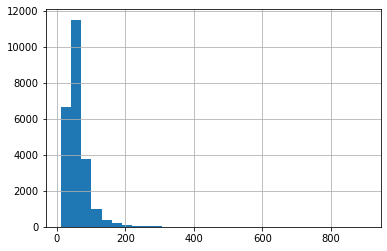

In [60]:
#код ревьюера
data2 = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
(data2['total_area']).hist(bins=30);

### Проведите исследовательский анализ данных

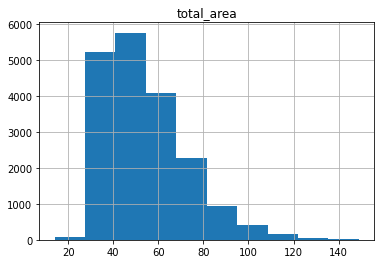

In [61]:
data_normal.hist('total_area');

- так как на предобработке мы выявили что площадь квартир от 12 до 114, остальное является выбрасами, как редкие исключение возьмем квартиры до 150 кв. м. ***
- видно что большая часть квартир по площади от 20 до 80 кв. м., но при этом есть и квартиры по площади 800 кв.м. но для точности данный сделал срез до 150 кв.м., что бы график был точнее.

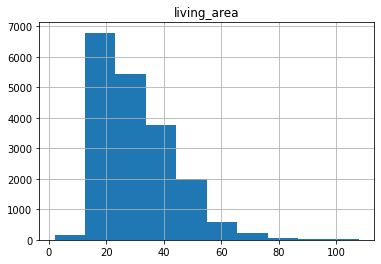

In [62]:
data_normal.hist('living_area');

- Делаем вывод, что основная жилая площадь квартир от 18 кв.м. до 62 кв.м.

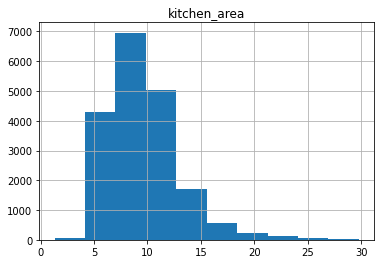

In [63]:
data_normal.hist('kitchen_area');

- По графику в основном площадь кухони ворьируется от 4 кв.м. до 17 кв.м

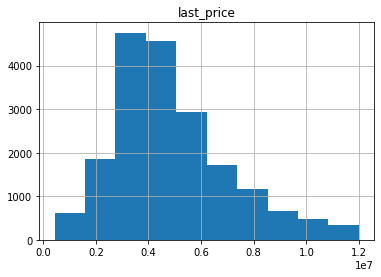

In [64]:
data_normal.hist('last_price');

- По графику видно, что большинство квартир продается в диапозоне 2млн. - 6 млн. руб.

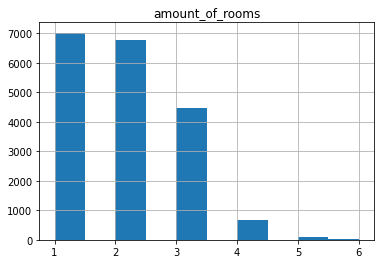

In [65]:
data_normal.hist('amount_of_rooms');

- Понятно что в основном продаются квартиры от 1 до 3 комнат.

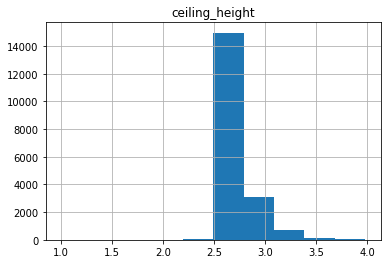

In [66]:
data_normal.hist('ceiling_height');

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br>Высота потолков в большенстве квартир от 2.2 до 3.3 метров.
</div>

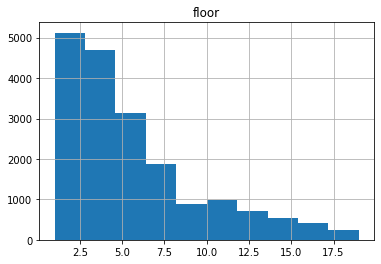

In [67]:
#plt.ylim(0, 20)
#data.boxplot('floor');
data_normal = data_normal[data_normal['floor'] < 20]
data_normal.hist('floor');


- Получается основная масса квартир продается до 8 этажа, потом спрос падает.

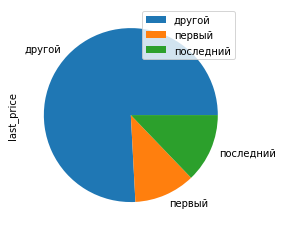

In [68]:
data_normal.groupby(['floor_status']).sum().plot(kind='pie', y = 'last_price');

- по круговой диаграмме видно, что 1/10 квартир продается на 1ом этаже, 2/10 квартир на последнем этаже, остальные разбросанны между ними.

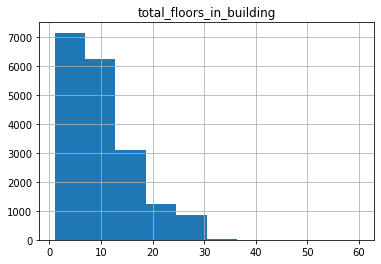

In [69]:
 #data_normal = data_normal[data_normal['total_floors_in_building'] < 40]
data_normal.hist('total_floors_in_building');

- Обычно в здании, в котором продается квартира до 30ти этажей.

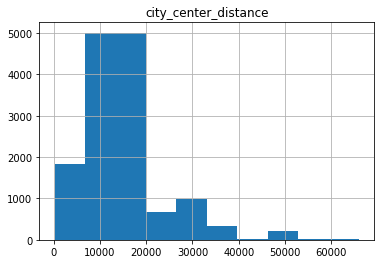

In [70]:
data_normal.hist('city_center_distance');

- Большая часть квартир продается в радиусе 20ти км. от центра.

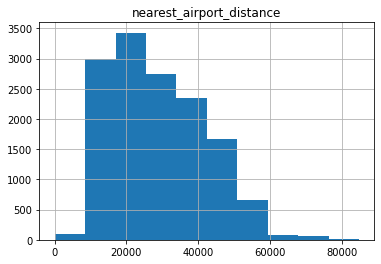

In [71]:
data_normal.hist('nearest_airport_distance');

- А до аэропорта квартиры распологаются в радиусе от 10ти км. до 60ти км.

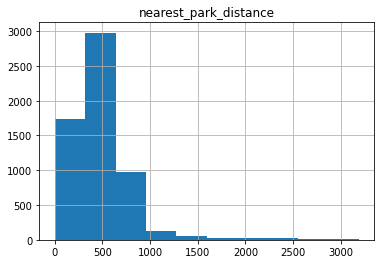

In [72]:
data_normal.hist('nearest_park_distance');

- Парк обычно расположен в келометре от парка, но очень много квартир которые в 500тах м. от парка.

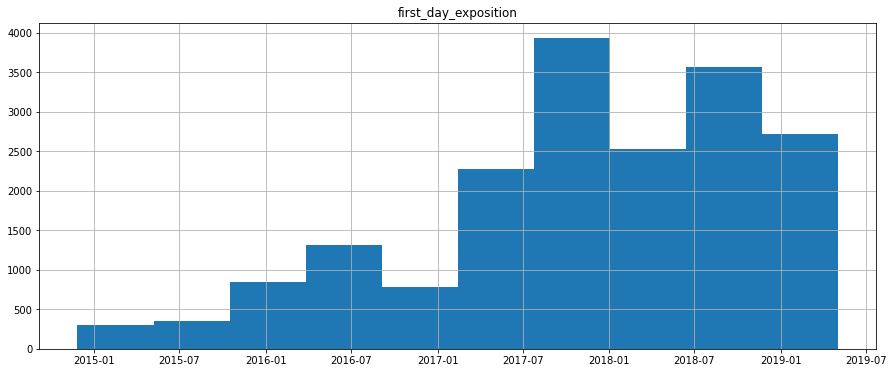

In [73]:
data_normal.hist('first_day_exposition', figsize=(15,6));

- В начале 2017 года был всплеск продаж квартир, пик продаж был в июле 2017 и остается стабильно высоким.

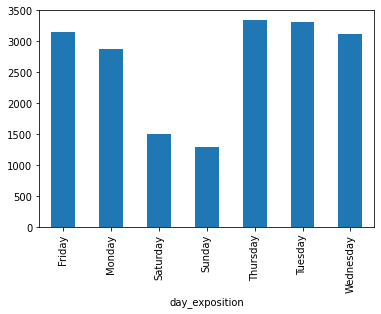

In [74]:
group = data_normal.groupby('day_exposition')['day_exposition'].count()
group.plot(kind='bar');

- в субботу и воскресенье квартиры продовались плохо.

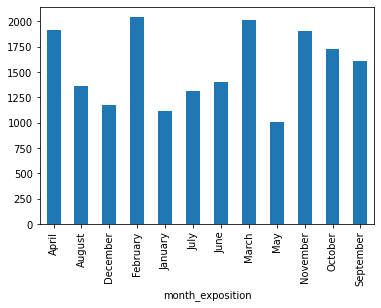

In [75]:
group = data_normal.groupby('month_exposition')['month_exposition'].count()
group.plot(kind='bar');

- высокие продажи в феврале и марте, самые низкие продажи в мае.

In [76]:
data_normal['days_exposition'].describe()

count    16256.000000
mean       177.791462
std        213.498062
min          1.000000
25%         43.000000
50%         97.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

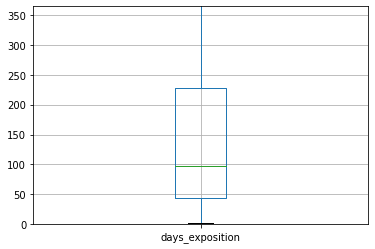

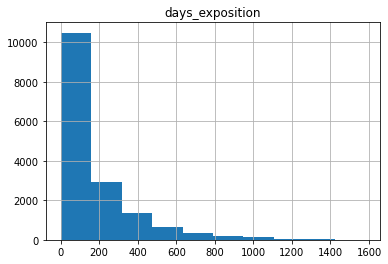

In [77]:
plt.ylim(0, 365)
data_normal.boxplot('days_exposition');
plt.show()
data_normal.hist('days_exposition');

In [78]:
data_normal['days_exposition'].mode()

0    45.0
dtype: float64

 - всреднем квартиры продавались за 45 дней.
 - но квартиры могли продоваться и 360 дней и это нормально,если больше что было не так или недвижимость была дорогой, но некоторые квартиры долго не продовались, больше 600 дней.

In [79]:
data_normal.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition,floor_status,cityCenters_distance_km
1,поселок шушары,40.4,1,18.6,11.0,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079,Tuesday,December,2018,первый,19.0
2,санкт-петербург,56.0,4,34.3,8.3,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015,другой,14.0
5,городской поселок янино-1,30.4,5,14.4,9.1,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474,Monday,September,2018,другой,NaN
6,поселок парголово,37.3,6,10.6,14.4,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456,Thursday,November,2017,другой,19.0
9,санкт-петербург,61.0,7,43.6,6.5,2.500000,3,2.0,9.0,False,False,False,18,5400000.0,2017-02-26,289.0,15008.0,50898.0,0.0,NaN,0.0,NaN,пригород,88524.590164,Sunday,February,2017,другой,15.0


In [80]:
corr = data_normal[['last_price',\
           'total_area',\
           'floor',\
           'living_area',\
           'kitchen_area',\
           'amount_of_rooms',\
           'floor_status',\
           'day_exposition',\
           'month_exposition',\
           'year_exposition',\
           'days_exposition',\
           'first_day_exposition'
           ]].corr()
corr

,last_price,total_area,floor,living_area,kitchen_area,amount_of_rooms,year_exposition,days_exposition
last_price,1.000000,0.701504,0.142545,0.579997,0.493951,0.454580,0.000821,0.072527
total_area,0.701504,1.000000,-0.029350,0.918276,0.436472,0.806939,-0.072084,0.121452
floor,0.142545,-0.029350,1.000000,-0.130730,0.223820,-0.163975,0.011527,-0.045777
living_area,0.579997,0.918276,-0.130730,1.000000,0.161788,0.898562,-0.058138,0.109080
kitchen_area,0.493951,0.436472,0.223820,0.161788,1.000000,0.044238,-0.044352,0.055809
amount_of_rooms,0.454580,0.806939,-0.163975,0.898562,0.044238,1.000000,-0.042157,0.094493
year_exposition,0.000821,-0.072084,0.011527,-0.058138,-0.044352,-0.042157,1.000000,-0.598792
days_exposition,0.072527,0.121452,-0.045777,0.109080,0.055809,0.094493,-0.598792,1.000000


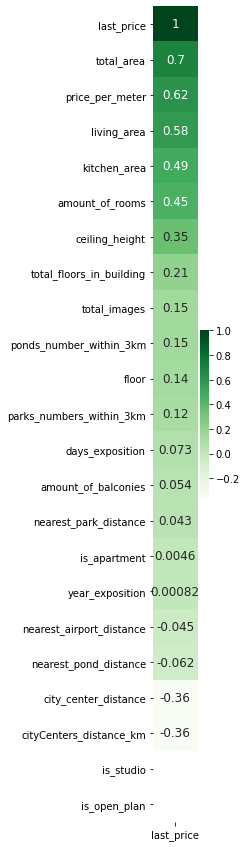

In [81]:
import seaborn as sns
plt.figure(figsize=(1,15))
sns.heatmap(data_normal.corr()[['last_price']].sort_values(by='last_price', ascending=False), cmap="Greens", 
            annot=True, annot_kws={'size':12});

На стоимость итоговую квартиры сильнее всего влияет общая площадь, жилая площадь и площадь кухни (последние переменные могут зависеть от общей площади). Количество комнат так-же влияет на цену. А вот этаж играет уже заметно меньшую роль. 

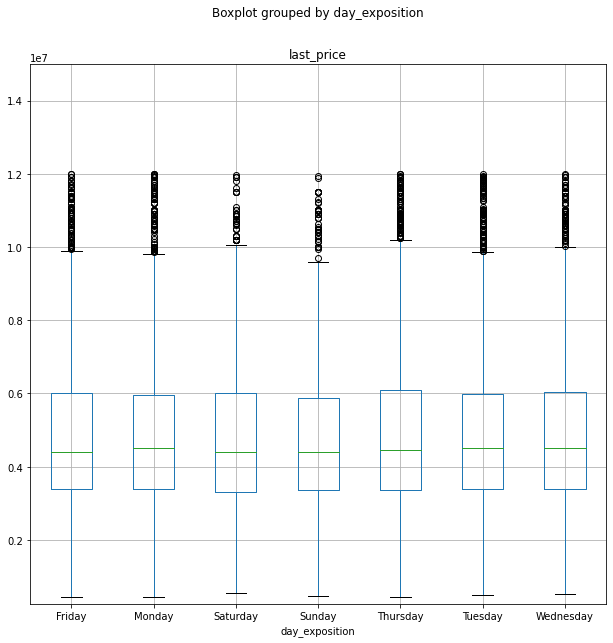

In [82]:
plot = data_normal.boxplot('last_price', by='day_exposition',figsize=(10,10)).set_ylim(250000,15000000)


- Все в пределах нормы, единственное можно заметить, что объявления выставленные в понедельник стоят слегка меньше остальных

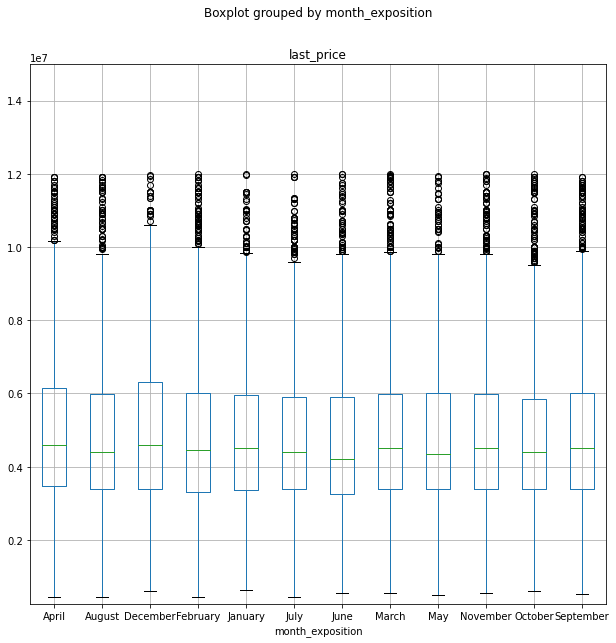

In [83]:
plot = data_normal.boxplot('last_price', by='month_exposition',figsize=(10,10)).set_ylim(250000,15000000)


- В целом все в пределах нормы, стоит выделить декабрь - ценник выразимо больше других месяцев

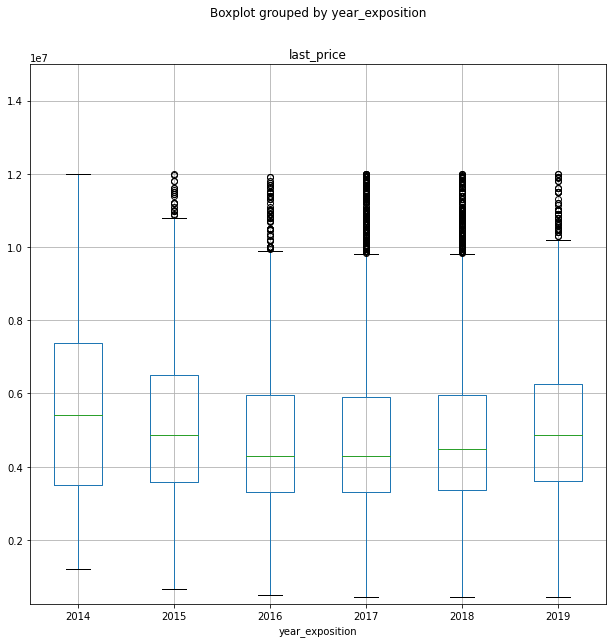

In [84]:
plot = data_normal.boxplot('last_price', by='year_exposition',figsize=(10,10)).set_ylim(250000,15000000)


- В целом все держится примерно на одном уровне, но 2014 выбивается из общей картины - момент до старта экономического кризиса

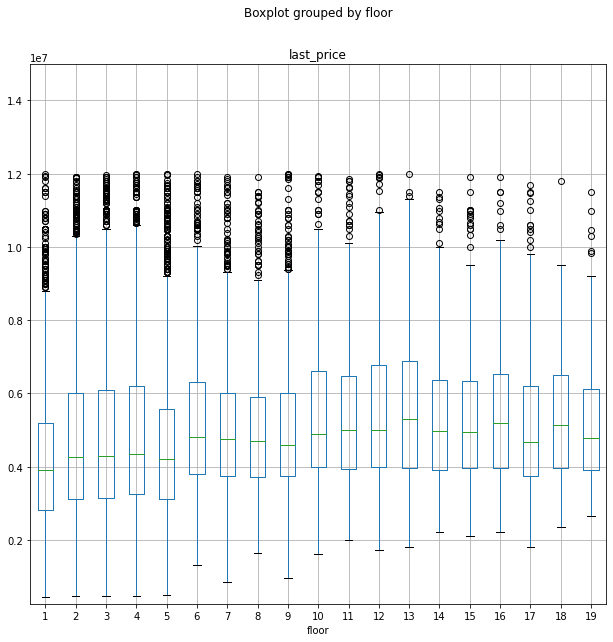

In [85]:
plot = data_normal.boxplot('last_price', by='floor',figsize=(10,10)).set_ylim(250000,15000000)


- Вспомним про статус этажей и рассмотрим уже их

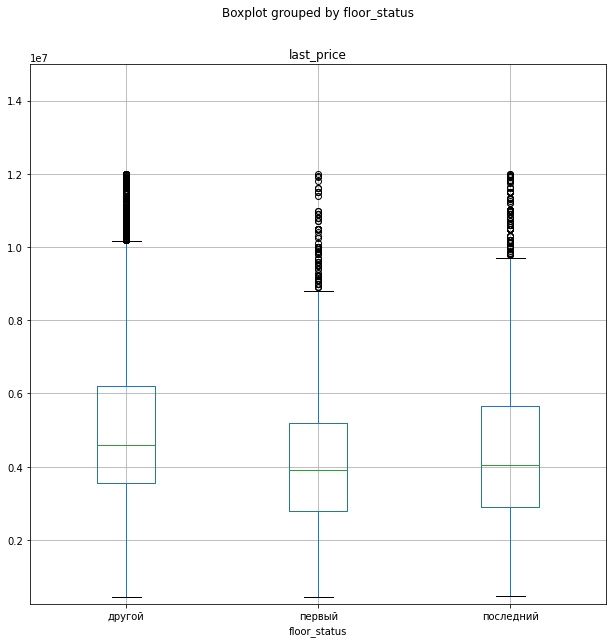

In [86]:
plot = data_normal.boxplot('last_price', by='floor_status',figsize=(10,10)).set_ylim(250000,15000000)


 Явно видно, что квартиры на первом этаже стоят меньше

In [87]:
pivot_table_total_area = data_normal.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']

In [88]:
pivot_table_total_area.sort_values('median', ascending = False)

,mean,count,median
total_area,,,
104.10,1.199900e+07,1,11999000.0
83.82,1.199500e+07,1,11995000.0
112.10,1.198388e+07,1,11983878.0
120.60,1.197000e+07,1,11970000.0
96.38,1.196800e+07,1,11968000.0
94.15,1.193900e+07,1,11939000.0
108.50,1.193500e+07,1,11935000.0
106.50,1.190000e+07,1,11900000.0
60.84,1.190000e+07,1,11900000.0


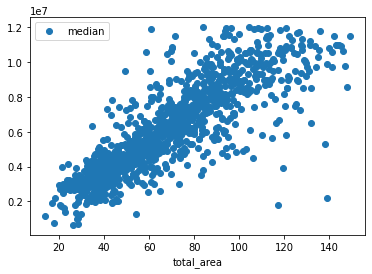

In [89]:
pivot_table_total_area.plot(y = 'median', style = 'o');

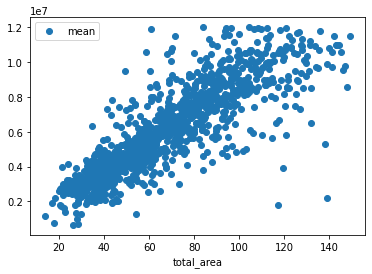

In [90]:
pivot_table_total_area.plot(y = 'mean', style = 'o');

In [91]:
data_normal['total_area'].corr(data_normal['last_price'])

0.7015040398736295

- Видна устойчивая тенденция: больше площадь -> больше цена. Корреляция Пирсона = 0.7015 -> высокая 

0.5799974925004501

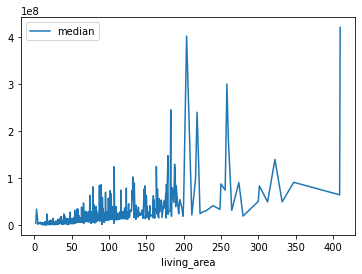

In [92]:
pivot_table_living = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_living.columns = ['mean', 'count', 'median']
pivot_table_living.plot(y = 'median')

pivot_table_living.sort_values('median', ascending = False)

data_normal['living_area'].corr(data['last_price'])

- Как видим мы имеем дело со средней корреляцией, действительно - чем выше площадь спальни, тем выше пики и в среднем цена за квартиру

0.4939506250420348

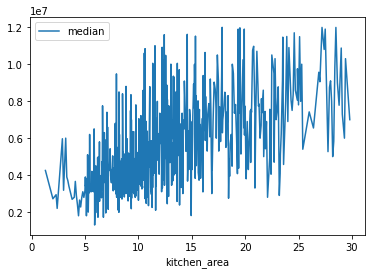

In [93]:
pivot_table_kitchen = data_normal.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_kitchen.columns = ['mean', 'count', 'median']
pivot_table_kitchen.plot(y = 'median')

pivot_table_kitchen.sort_values('median', ascending = False)

data_normal['kitchen_area'].corr(data_normal['last_price'])

- Как видно с кухней зависимость слабая - люди не так сильно ориентируются на размер кухни при выборе квартиры

- Все в пределах динамики нормы экономики. День, месяц, год не играют особой разницы. 
- Однозначно можно сказать, что квартиры на первом этаже стоят дешевле остальных и в 2014 году были большие цены на квартиры  в связи с более благоприятной экономической ситуацией в стране и на рынке. Так-же людям важнее размер спальни, чем кухни. Есть зависимость между размером квартиры и ее ценой


In [94]:
#сортируем обьявления
top_ads = data_normal['town_name'].value_counts()
#выводим топ 10 городов
top_ads = top_ads[:10]
#удобный список для вычислений
top_ads = top_ads.index.tolist()
#создаем пустой список для заполнения медианным значением кв.м.
med_price_square_meter = []
#заполняем список значением
for city in top_ads:
    price = data_normal[data_normal['town_name'] == city]['price_per_meter'].median()
    med_price_square_meter.append(price)

- Теперь делаем то же самое только для нахождения медианы по общей стоимости квартир.

In [95]:
med_price = []

for city in top_ads:
    price = data_normal[data_normal['town_name'] == city]['last_price'].median()
    med_price.append(price)

- Строим таблицу из имеющихся данных

In [96]:
table_med_price = pd.DataFrame(
    {'город': top_ads,
     'средняя стоимость кв. м., тыс. руб': med_price_square_meter,
     'средняя стоимость квартиры тыс. руб.': med_price
}).sort_values(by='средняя стоимость кв. м., тыс. руб', ascending=False)
#отсартированная таблица
table_med_price

,город,"средняя стоимость кв. м., тыс. руб",средняя стоимость квартиры тыс. руб.
0,санкт-петербург,101333.333333,5150000.0
5,пушкин,98471.986418,4950000.0
8,деревня кудрово,92152.199762,3830000.0
7,поселок парголово,91040.462428,4140000.0
1,поселок мурино,84285.714286,3590000.0
2,поселок шушары,77355.715871,3970000.0
4,колпино,74689.878234,3600000.0
6,гатчина,67695.961995,3050000.0
3,всеволожск,65789.473684,3450000.0
9,выборг,58307.692308,2800000.0


В Питере дороже всего, в Выборге дешевле

Пересчитал код ниже

In [97]:
data_normal.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition,floor_status,cityCenters_distance_km
1,поселок шушары,40.4,1,18.6,11.0,2.670136,1,2.0,11.0,False,False,False,7,3350000.0,2018-12-04,81.0,18603.0,12817.0,0.0,NaN,0.0,NaN,пригород,82920.792079,Tuesday,December,2018,первый,19.0
2,санкт-петербург,56.0,4,34.3,8.3,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015,другой,14.0
5,городской поселок янино-1,30.4,5,14.4,9.1,2.780516,1,0.0,12.0,False,False,False,10,2890000.0,2018-09-10,55.0,NaN,NaN,NaN,NaN,NaN,NaN,область,95065.789474,Monday,September,2018,другой,NaN
6,поселок парголово,37.3,6,10.6,14.4,2.670136,1,1.0,26.0,False,False,False,6,3700000.0,2017-11-02,155.0,19143.0,52996.0,0.0,NaN,0.0,NaN,пригород,99195.710456,Thursday,November,2017,другой,19.0
9,санкт-петербург,61.0,7,43.6,6.5,2.500000,3,2.0,9.0,False,False,False,18,5400000.0,2017-02-26,289.0,15008.0,50898.0,0.0,NaN,0.0,NaN,пригород,88524.590164,Sunday,February,2017,другой,15.0


In [98]:
data_spb = data_normal.query('town_name == "санкт-петербург"')
data_spb.head(5)

,town_name,total_area,floor,living_area,kitchen_area,ceiling_height,amount_of_rooms,amount_of_balconies,total_floors_in_building,is_apartment,is_studio,is_open_plan,total_images,last_price,first_day_exposition,days_exposition,city_center_distance,nearest_airport_distance,parks_numbers_within_3km,nearest_park_distance,ponds_number_within_3km,nearest_pond_distance,distance_category,price_per_meter,day_exposition,month_exposition,year_exposition,floor_status,cityCenters_distance_km
2,санкт-петербург,56.0,4,34.3,8.3,2.670136,2,0.0,5.0,False,False,False,10,5196000.0,2015-08-20,558.0,13933.0,21741.0,1.0,90.0,2.0,574.0,пригород,92785.714286,Thursday,August,2015,другой,14.0
9,санкт-петербург,61.0,7,43.6,6.5,2.500000,3,2.0,9.0,False,False,False,18,5400000.0,2017-02-26,289.0,15008.0,50898.0,0.0,NaN,0.0,NaN,пригород,88524.590164,Sunday,February,2017,другой,15.0
10,санкт-петербург,39.6,3,20.3,8.5,2.670000,1,0.0,12.0,False,False,False,5,5050000.0,2017-11-16,137.0,13878.0,38357.0,1.0,310.0,2.0,553.0,пригород,127525.252525,Thursday,November,2017,другой,14.0
15,санкт-петербург,39.0,5,20.5,7.6,2.670136,1,1.0,14.0,False,False,False,16,4650000.0,2017-11-18,19.0,14259.0,12900.0,1.0,590.0,1.0,296.0,пригород,119230.769231,Saturday,November,2017,другой,14.0
16,санкт-петербург,82.0,1,55.6,9.0,3.050000,3,0.0,5.0,False,False,False,11,6700000.0,2017-11-23,397.0,10698.0,22108.0,3.0,420.0,0.0,NaN,окраины,81707.317073,Thursday,November,2017,первый,11.0


,price_per_meter
cityCenters_distance_km,
0.0,116348.084631
1.0,117335.193455
2.0,112897.221700
3.0,108235.045330
4.0,113385.884377
5.0,119910.719880
6.0,120368.461276
7.0,116551.291818
8.0,114828.692472


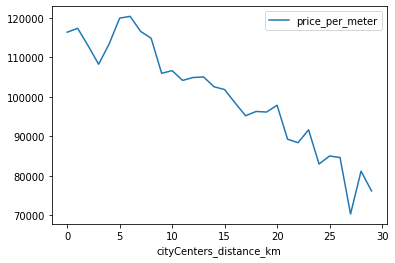

In [99]:
pivot_table_km = data_normal.query('town_name == "санкт-петербург" and cityCenters_distance_km < 60').pivot_table(index = 'cityCenters_distance_km', values = 'price_per_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

- Как видно стабильный тренд на уменьшения ценника по удалению от центра за исключением резкого перепада, походу неблагополучный район

,last_price
cityCenters_distance_km,
0.0,7.568571e+06
1.0,8.285489e+06
2.0,8.066158e+06
3.0,7.325722e+06
4.0,7.718627e+06
5.0,7.692061e+06
6.0,7.092238e+06
7.0,6.708136e+06
8.0,6.631723e+06


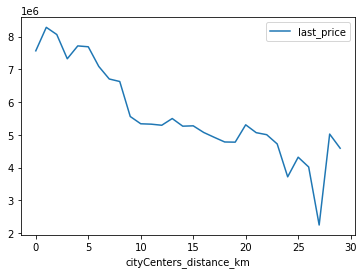

In [100]:
pivot_price_table_km = data_normal.query('town_name == "санкт-петербург" and cityCenters_distance_km < 60').pivot_table(index = 'cityCenters_distance_km', values = 'last_price', aggfunc = 'mean')
pivot_price_table_km.plot()
pivot_price_table_km

- Существует резкий перепад, походу неблагополучный район

<!-- Рассмотрим зависимость цены от удаления от центра
Рассмотрим границы 9-13-16-65 км -->

### Вывод
Как видно мы имеем стабильно убывающий график зависимости цены от расстояния до центра. В Санкт-Петербурге самые дорогие квартиры. Все в пределах динамики нормы экономики. День, месяц, год не играют особой разницы. Однозначно можно сказать, что квартиры на первом этаже стоят дешевле остальных и в 2014 году были большие цены на квартиры в связи с более благоприятной экономической ситуацией в стране и на рынке. Так-же людям важнее размер спальни, чем кухни. Есть зависимость между размером квартиры и ее ценой

# Вывод
Срок продажи квартир

- всреднем квартиры продавались за 45 дней.
- но квартиры могли продоваться и 360 дней и это нормальноно если дольше это долго, но некоторые квартиры долго не продовались, больше 600 дней.

Факторы, сильнее всего влияющие на стоимость

- Итоговая площадь(в том числе жилая) 
- Жилая площадь
- Количество комнат
- Расстояние до пруда
- Площадь кухни

Условный этаж и высота потолка играют в разы меньшую роль

Чем больше площадь квартиры, тем выше цена. Чем больше цена за квадратный метр, тем выше цена .Чем выше доля жилой площади/площадь кухни, тем выше цена. Людям важнее доля жилой площади, чем кухни. Чем больше комнат, тем выше цена.

- Дороже всего квадратный метр в Санкт-Петербурге - 101333.3
- Дешевле всего квадратный метр в Выборге - 58158.3

Состояние рынка в Санкт-Петербурге

- Чем ближе к центру, тем дороже квартира. В самом центре квартиры стоят в разы дороже.
- Существует резкий перепад, походу неблагополучный район

Состояние рынка в целом

- В начале 2017 года был всплеск продаж.
- в настоящее время продажи держаться на высоком уровне
- последний год рынок держиться на одном уровне с небольшими колебаниями